# Analysis Of  My Youtoube Data

In [9]:
## import necessary libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression


#### Creating Dataframes

###### Data1

In [10]:
##converting data into a pandas dataframe
json_file_path = r"C:\Users\Hp\source\cs210/you.json"
data1=pd.read_json(json_file_path)

#### Preprocessing Data

In [81]:
# Convert the time column to the format (day-month-year-time)
data1['time'] = pd.to_datetime(data1['time'])
data1['Formatted_Time'] = data1['time'].dt.strftime('%d-%m-%Y-%X')


In [12]:
## Create a new column for the hours
list_a=[]
for _ in data1["Formatted_Time"]:
    list_a.append((_.split("-")[3].split(":")[0]))
data1["Only_hours"]=list_a    


In [13]:
##checking are there any Nan values
data1.isnull().values.any()

True

In [83]:
## Check for the time column
data1["time"].isnull().sum().sum()

0

In [14]:
data1.isnull().sum().sum()

48017

####  Analyzing Data

In [16]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25445 entries, 0 to 25444
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   header            25445 non-null  object             
 1   title             25445 non-null  object             
 2   titleUrl          25147 non-null  object             
 3   subtitles         18041 non-null  object             
 4   time              25445 non-null  datetime64[ns, UTC]
 5   products          25445 non-null  object             
 6   activityControls  25445 non-null  object             
 7   description       5194 non-null   object             
 8   details           5381 non-null   object             
 9   Formatted_Time    25445 non-null  object             
 10  Only_hours        25445 non-null  object             
dtypes: datetime64[ns, UTC](1), object(10)
memory usage: 2.1+ MB


In [17]:
data1.shape

(25445, 11)

### Data Analysis

##### Null Hypothesis: There is no relationship between the time I spend on YouTube and the months of the year.

#### Alternative Hypothesis: There is a significant relationship between the time I spend on YouTube and the months of the year.


In [26]:
# Calculate average hourly usage for Summer and Non-Summer
# Create a column to identify summer and non-summer months
data1["Month"] = pd.to_datetime(data1["Formatted_Time"]).dt.month
data1["Hour"] = pd.to_datetime(data1["Formatted_Time"]).dt.hour
data1["Season"] = data1["Month"].apply(lambda x: "Summer" if 6 <= x <= 8 else "Non-Summer")
average_hourly_usage = data1.groupby(['Season', 'Hour']).size().reset_index(name='Frequency')
average_hourly_usage = average_hourly_usage.pivot(index='Hour', columns='Season', values='Frequency')
average_hourly_usage['Total'] = average_hourly_usage['Summer'] + average_hourly_usage['Non-Summer']
average_hourly_usage['Summer_Percentage'] = (average_hourly_usage['Summer'] / average_hourly_usage['Total']) * 100

print(average_hourly_usage)


Season  Non-Summer  Summer   Total  Summer_Percentage
Hour                                                 
0             41.0    14.0    55.0          25.454545
1             89.0     NaN     NaN                NaN
2            223.0    41.0   264.0          15.530303
3            383.0    84.0   467.0          17.987152
4             70.0    89.0   159.0          55.974843
5             57.0    18.0    75.0          24.000000
6            360.0    88.0   448.0          19.642857
7            753.0   211.0   964.0          21.887967
8            731.0   301.0  1032.0          29.166667
9           1135.0   416.0  1551.0          26.821406
10          1342.0   439.0  1781.0          24.649074
11           765.0   268.0  1033.0          25.943853
12           945.0   209.0  1154.0          18.110919
13           987.0   193.0  1180.0          16.355932
14           991.0   208.0  1199.0          17.347790
15          1035.0   187.0  1222.0          15.302782
16          1343.0   238.0  

In [27]:



# Extract month and time components for each timestamp
data1["Month"] = pd.to_datetime(data1["Formatted_Time"]).dt.month
data1["Hour"] = pd.to_datetime(data1["Formatted_Time"]).dt.hour
data1["Season"] = data1["Month"].apply(lambda x: "Summer" if 6 <= x <= 8 else "Non-Summer")

#contingency table
contingency_table = pd.crosstab(data1["Season"], data1["Hour"])

#Chi-squared test
chi2, p, _, _ = chi2_contingency(contingency_table)


print("Chi-square:", chi2)
print("P-value:", p)


Chi-square: 660.2848340005949
P-value: 1.0134460933486877e-124


In [20]:
contingency_table

Hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Season,,,,,,,,,,,,,,,,,,,,,
Non-Summer,41,89,223,383,70,57,360,753,731,1135,...,991,1035,1343,1769,1325,1334,1390,1431,1108,352
Summer,14,0,41,84,89,18,88,211,301,416,...,208,187,238,189,367,564,414,409,331,208


In [22]:


# Extract hour component
data1["Hour"] = pd.to_datetime(data1["Formatted_Time"]).dt.hour


summer_hours = data1[data1['Season'] == 'Summer']['Hour']
non_summer_hours = data1[data1['Season'] == 'Non-Summer']['Hour']

# Two-sample t-test
t_statistic, p_value_ttest = ttest_ind(summer_hours, non_summer_hours, equal_var=False)

print(f"Two-sample t-test t-statistic: {t_statistic}, p-value: {p_value_ttest}")


Two-sample t-test t-statistic: -0.07776808911333975, p-value: 0.9380143953479358


In [23]:


# Create a binary variable for season (1 for summer, 0 for non-summer)
data1['Season_Binary'] = data1['Season'].apply(lambda x: 1 if x == 'Summer' else 0)


X = sm.add_constant(data1['Hour'])
y = data1['Season_Binary']

# Logistic regression model
logistic_model = sm.Logit(y, X).fit()


print(logistic_model.summary())


Optimization terminated successfully.
         Current function value: 0.521285
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:          Season_Binary   No. Observations:                25445
Model:                          Logit   Df Residuals:                    25443
Method:                           MLE   Df Model:                            1
Date:                Thu, 18 Jan 2024   Pseudo R-squ.:               2.443e-07
Time:                        12:57:52   Log-Likelihood:                -13264.
converged:                       True   LL-Null:                       -13264.
Covariance Type:            nonrobust   LLR p-value:                    0.9358
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.2881      0.045    -28.859      0.000      -1.376      -1.201
Hour          -0.0002      0.

In [72]:

X = data1[['Hour']]  # Features
y = data1['Season']  # Target variable


In [73]:


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [74]:


model = DecisionTreeClassifier()


In [75]:
model.fit(X_train, y_train)


DecisionTreeClassifier()

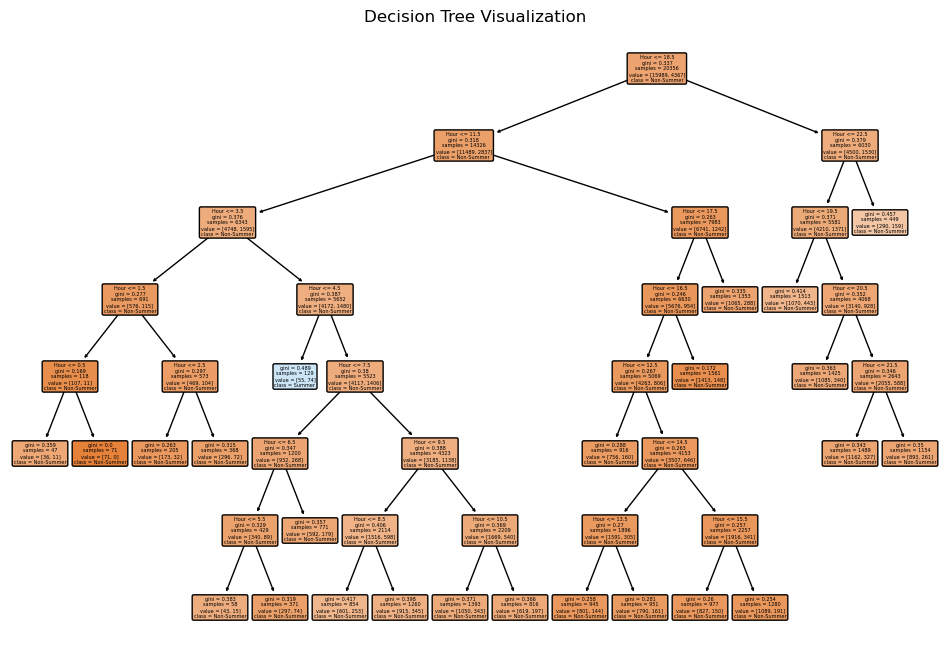

In [76]:



model = DecisionTreeClassifier()
model.fit(X_train, y_train)

# Plot the decision tree
plt.figure(figsize=(12, 8))
plot_tree(model, feature_names=['Hour'], class_names=['Non-Summer', 'Summer'], filled=True, rounded=True)
plt.title('Decision Tree Visualization')
plt.show()


In [58]:
from sklearn.metrics import classification_report, confusion_matrix

# Assuming you have a test set
X_test = data1[['Hour']]
y_test = data1['Season']

# Make predictions
y_pred = model.predict(X_test)

# Evaluate performance
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[19889    70]
 [ 5397    89]]

Classification Report:
              precision    recall  f1-score   support

  Non-Summer       0.79      1.00      0.88     19959
      Summer       0.56      0.02      0.03      5486

    accuracy                           0.79     25445
   macro avg       0.67      0.51      0.46     25445
weighted avg       0.74      0.79      0.70     25445



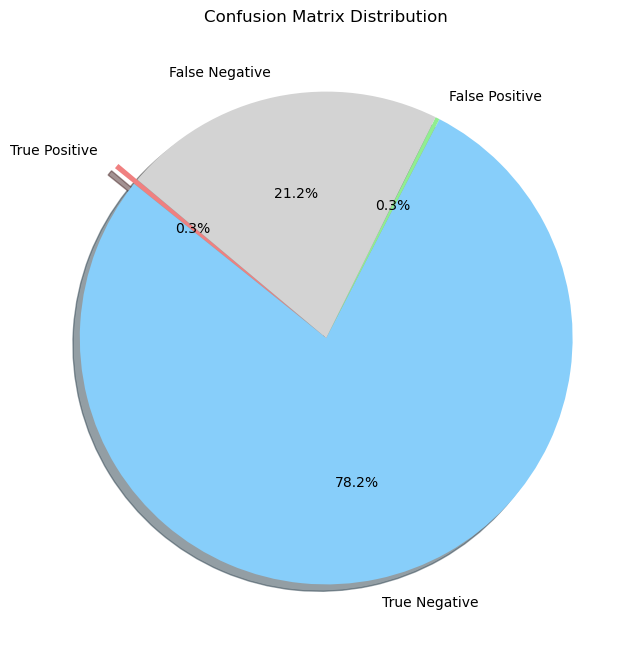

In [63]:
import matplotlib.pyplot as plt

# Confusion Matrix values
TP = 89
TN = 19889
FP = 70
FN = 5397

# Create a pie chart
labels = ['True Positive', 'True Negative', 'False Positive', 'False Negative']
sizes = [TP, TN, FP, FN]
colors = ['lightcoral', 'lightskyblue', 'lightgreen', 'lightgray']
explode = (0.1, 0, 0, 0)  # explode the 1st slice (i.e., 'True Positive')

plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Confusion Matrix Distribution')
plt.show()


In [64]:


# Assuming you have already defined and prepared X_train, X_test, y_train, y_test
model = LogisticRegression()
model.fit(X_train, y_train)

# Evaluate the model
accuracy = model.score(X_test, y_test)
print(f'Model Accuracy: {accuracy:.2f}')


Model Accuracy: 0.78


In [70]:

accuracy_scores = cross_val_score(model_rf, X, y, cv=5)  
print(f'Cross-Validation Accuracy: {accuracy_scores.mean():.2f}')


Cross-Validation Accuracy: 0.77
